# Predicting Credit Ratings

This notebook contains my very first Data Science / Machine Learning project, to learn about and apply different ML algorithms on a German Credit Data Set to predict creditworthiness.

### 1. Importing Packages & Data

First off, I'll import the packages I'll need in this project, this includes:
- pandas: using dataframes makes manipulating the data easier
- numpy: for matrix maths
- scikit-learn: for applying distance metrics in K-means clustering
- pytorch:
- matplotlib: for data visualisations and graphs.

In [18]:
import pandas as pd
import numpy as np
import sklearn as skl
import torch as pyt
import matplotlib.pyplot as plt

Next I'll import the data set as a pandas DataFrame. 

I am using the German Credit DataFrame from the UCI Machine Learning repository:

https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29 

In [6]:
german_credit_data_original = pd.read_csv(r"C:\Users\nicholst\OneDrive - Pension Services Corporation Ltd\Projects\Credit Risk ML\German Credit Data\german.csv")
print(german_credit_data_original)

    AccBalance  Duration CreditHistory Purpose  Amount Savings Employment  \
0          A11         6           A34     A43    1169     A65        A75   
1          A12        48           A32     A43    5951     A61        A73   
2          A14        12           A34     A46    2096     A61        A74   
3          A11        42           A32     A42    7882     A61        A74   
4          A11        24           A33     A40    4870     A61        A73   
..         ...       ...           ...     ...     ...     ...        ...   
995        A14        12           A32     A42    1736     A61        A74   
996        A11        30           A32     A41    3857     A61        A73   
997        A14        12           A32     A43     804     A61        A75   
998        A11        45           A32     A43    1845     A61        A73   
999        A12        45           A34     A41    4576     A62        A71   

     Rate  Status Sex  ... Property  Age OtherPlans  Housing ExistingCredit

### 2. K-Nearest Neighbours (KNN)

First I'll try using the K Nearest Neighbours to determine Credit Rating (Good or Bad) from a number of features in the data. 

As you can see from the above DataFrame, the data is of mixed type i.e. contains continuous data in some columns (e.g. Duration) and categorical data in the rest (e.g. Sex). This means that standard distance metrics like the Euclidean distance will not work in this case. This is because the Euclidean distance metirc (i.e. straight line in N-dimensions) is not calculable when any of the dimensions are not continuous (i.e. not Real numbers). 

However, I can use an alternative method: Gower's distance. This uses the "Manhattan distance" to measure the dissimilarity of the continuous features and the "Dice distance" for the categorical features.

First let's decide on which features I'll use. I'll start by using a set of the 10 features I believe to be the most relevant: Age,
AccBalance, CreditHistory, Purpose, Employment, Savings, ExistingCredits, Property, Duration and Rate.

I'll cut down the DataFrame to only include these features. 

In [7]:
feature_list = ['Age','AccBalance','CreditHistory','Purpose','Employment','Savings','ExistingCredits','Property','Duration','Rate']
german_credit_data = german_credit_data_original[feature_list]
print(german_credit_data)

     Age AccBalance CreditHistory Purpose Employment Savings  ExistingCredits  \
0     67        A11           A34     A43        A75     A65                2   
1     22        A12           A32     A43        A73     A61                1   
2     49        A14           A34     A46        A74     A61                1   
3     45        A11           A32     A42        A74     A61                1   
4     53        A11           A33     A40        A73     A61                2   
..   ...        ...           ...     ...        ...     ...              ...   
995   31        A14           A32     A42        A74     A61                1   
996   40        A11           A32     A41        A73     A61                1   
997   38        A14           A32     A43        A75     A61                1   
998   23        A11           A32     A43        A73     A61                1   
999   27        A12           A34     A41        A71     A62                1   

    Property  Duration  Rat

Now that I have my cut-down features DataFrame I will apply the manhattan distance to all of the numeric features. 

In [8]:
from sklearn.neighbors import DistanceMetric

# Get the dtype for each column
data_types = german_credit_data.dtypes

# Set up dictionary to save distances
s = {}

# For each column in the df calculate manhattan distance if numeric
for col in german_credit_data:
    if data_types[col] != "object":

        # Calculating matrix of pairwise differences
        s[col] = DistanceMetric.get_metric('manhattan').pairwise(german_credit_data[[col]])

        # Normalising the matrix 
        s[col] = s[col]/max(np.ptp(german_credit_data[[col]]),1)

# Print an example
print("Age")
print(s['Age'])

Age
[[0.         0.80357143 0.32142857 ... 0.51785714 0.78571429 0.71428571]
 [0.80357143 0.         0.48214286 ... 0.28571429 0.01785714 0.08928571]
 [0.32142857 0.48214286 0.         ... 0.19642857 0.46428571 0.39285714]
 ...
 [0.51785714 0.28571429 0.19642857 ... 0.         0.26785714 0.19642857]
 [0.78571429 0.01785714 0.46428571 ... 0.26785714 0.         0.07142857]
 [0.71428571 0.08928571 0.39285714 ... 0.19642857 0.07142857 0.        ]]


The remaining features are all categorical and as such I will now apply the Dice distance to them.

In [9]:
# For each column in the df calculate dice distance if non-numeric
for col in german_credit_data:
    if data_types[col] == "object":

        # Create a dummy data column
        dummy_df = pd.get_dummies(german_credit_data[[col]])

        # Calculating matrix of pairwise differences
        s[col] = DistanceMetric.get_metric('dice').pairwise(dummy_df)

        # Normalising the matrix 
        s[col] = s[col]/max(np.ptp(dummy_df),1)

# Print an example
print("AccBalance")
print(s["AccBalance"])

AccBalance
[[0. 1. 1. ... 1. 0. 1.]
 [1. 0. 1. ... 1. 1. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 ...
 [1. 1. 0. ... 0. 1. 1.]
 [0. 1. 1. ... 1. 0. 1.]
 [1. 0. 1. ... 1. 1. 0.]]


The Gowers distance can then be calculated using the formula below: 

d = Sum(si*wi)/Sum(wi)

Where: 
- si are the distances for each feature
- wi are the weights

We will use weights of 1 for all features to begin with. 


In [10]:
i = 0
for col in german_credit_data:
    if i == 0:
        gowers = s[col]
    else:
        gowers = np.add(gowers, s[col])
    i += 1
gowers = gowers / len(german_credit_data.columns)
print(gowers)
    
     

[[0.         0.64212185 0.54096639 ... 0.49394258 0.5692577  0.69544818]
 [0.64212185 0.         0.50115546 ... 0.44817927 0.27286415 0.54667367]
 [0.54096639 0.50115546 0.         ... 0.48630952 0.66162465 0.62114846]
 ...
 [0.49394258 0.44817927 0.48630952 ... 0.         0.37531513 0.6015056 ]
 [0.5692577  0.27286415 0.66162465 ... 0.37531513 0.         0.64047619]
 [0.69544818 0.54667367 0.62114846 ... 0.6015056  0.64047619 0.        ]]


We now have our full matrix of Gower distances between all of the 1000 records in the data set. 

Let's take the first record and find it's nearest 10 neighbours. And from this we can get a first guess probability for the person having a credit rating of "Good".


In [11]:
# Get just first row of distances
distances = list(gowers[0])

# Create a list of row nums
nums = [i+1 for i in range(1000)]
dist_map = dict(zip(distances,nums))

# Get IDs of the 10 nearest neighbours
distances.sort()
IDs = []
for i in range(0,10):
    dist = distances[i+1]
    ID = dist_map[dist]-1
    IDs += [ID]
print("IDs of the 10 nearest neighbours by Gower Distance:")
print(IDs)
print("")

# For each of these 10 records, get the Credit Rating
data_neighbours = german_credit_data_original.iloc[IDs]["CreditRating"]

# Count number of 1's 
good_count = german_credit_data_original.iloc[IDs]["CreditRating"].value_counts()[1]
length = len(data_neighbours)
prob = good_count / len(data_neighbours)
print("Probability of Good Credit: "+str(prob*100)+"%")

# Get the actual Credit Rating
Actual = german_credit_data_original.iloc[0]["CreditRating"]
if Actual == 1:
    Actual = "Good"
else:
    Actual = "Bad"
print(f"Actual Credit Rating: {Actual}")



IDs of the 10 nearest neighbours by Gower Distance:
[61, 135, 807, 179, 177, 115, 823, 71, 955, 16]

Probability of Good Credit: 100.0%
Actual Credit Rating: Good


Now I'll perform a loop to get the Probabilities and actual credit ratings of each row.

In [12]:
k = 10 
row_id = 0 
correct_count = 0
for row in gowers:

    # Get just first row of distances
    distances = list(row)

    # Create a list of row nums
    nums = [i+1 for i in range(1000)]
    dist_map = dict(zip(distances,nums))

    # Get IDs of the 10 nearest neighbours
    distances.sort()
    IDs = []
    for i in range(0,k):
        dist = distances[i+1]
        ID = dist_map[dist]-1
        IDs += [ID]

    # For each of these 10 records, get the Credit Rating
    data_neighbours = german_credit_data_original.iloc[IDs]["CreditRating"]

    # Count number of 1's
    try:
        good_count = german_credit_data_original.iloc[IDs]["CreditRating"].value_counts()[1]
    except:
        good_count = 0
    length = len(data_neighbours)
    prob = good_count / len(data_neighbours)

    # Get the actual Credit Rating
    Actual = german_credit_data_original.iloc[row_id]["CreditRating"]
    if Actual == 1:
        Actual = "Good"
    else:
        Actual = "Bad"

    # Determine if estimation is correct
    if prob > 0.5:
        if Actual == "Good":
            correct_count += 1
    else:
        if Actual == "Bad":
            correct_count += 1

    row_id += 1

# Display the results
print(f"Of 1000 records {str(correct_count)} were predicted correctly and {str(1000-correct_count)} were not")
print(f"This means the algorithm is {str(correct_count*100/1000)}% accurate when:")
print(f"k = {k}")


Of 1000 records 703 were predicted correctly and 297 were not
This means the algorithm is 70.3% accurate when:
k = 10


With an accuracy of 70.3% this algorithm does not achieve a much higher precision than just simply guessing that all records will have "Good" credit rating (as these make up 700 out of 1000 records), this is far from ideal. 

I'll now wrap this in a function and call this again for a range of values of k, to see if we can achieve any more accuracy. 

In [13]:
def test_knn(k,gowers_matrix):

    row_id = 0 
    correct_count = 0
    for row in gowers_matrix:

        # Get just first row of distances
        distances = list(row)

        # Create a list of row nums
        nums = [i+1 for i in range(1000)]
        dist_map = dict(zip(distances,nums))

        # Get IDs of the k nearest neighbours
        distances.sort()
        IDs = []
        for i in range(0,k):
            dist = distances[i+1]
            ID = dist_map[dist]-1
            IDs += [ID]

        # For each of these k records, get the Credit Rating
        data_neighbours = german_credit_data_original.iloc[IDs]["CreditRating"]

        # Count number of 1's
        try:
            good_count = german_credit_data_original.iloc[IDs]["CreditRating"].value_counts()[1]
        except:
            good_count = 0
        length = len(data_neighbours)
        prob = good_count / len(data_neighbours)

        # Get the actual Credit Rating
        Actual = german_credit_data_original.iloc[row_id]["CreditRating"]
        if Actual == 1:
            Actual = "Good"
        else:
            Actual = "Bad"

        # Determine if estimation is correct
        if prob > 0.5:
            if Actual == "Good":
                correct_count += 1
        else:
            if Actual == "Bad":
                correct_count += 1

        row_id += 1

    # Display the results
    print(f"Of 1000 records {str(correct_count)} were predicted correctly and {str(1000-correct_count)} were not")
    print(f"This means the algorithm is {str(correct_count*100/1000)}% accurate when:")
    print(f"k = {k}")
    print(f"")

test_knn(5,gowers)
test_knn(10,gowers)
test_knn(15,gowers)
test_knn(25,gowers)
test_knn(50,gowers)
test_knn(100,gowers)
#test_knn(999,gowers)

Of 1000 records 707 were predicted correctly and 293 were not
This means the algorithm is 70.7% accurate when:
k = 5

Of 1000 records 703 were predicted correctly and 297 were not
This means the algorithm is 70.3% accurate when:
k = 10

Of 1000 records 735 were predicted correctly and 265 were not
This means the algorithm is 73.5% accurate when:
k = 15

Of 1000 records 746 were predicted correctly and 254 were not
This means the algorithm is 74.6% accurate when:
k = 25

Of 1000 records 722 were predicted correctly and 278 were not
This means the algorithm is 72.2% accurate when:
k = 50

Of 1000 records 716 were predicted correctly and 284 were not
This means the algorithm is 71.6% accurate when:
k = 100



The highest accuracy acheived was 74.6% when k = 25, this is still not great...

I have two avenues to explore in order to try to improve this accuracy:

   1. Change the features in the feature list.  
   2. Adjust the weighting applied to the various features when calculating the distance metric. 

I'll now experiment by varying up the features in the selected feature list to again see if this can generate any better results. It may be that we are missing some features that are key for determining Credit Ratings. 

In [25]:
# Create a fully parameterisable function
def knn(data, target, features, weights, k, success_condition):
    '''
    This function tests the success rate of the KNN algorithm for predicting the value of a        binary valued target column based on a number of feature columns.

    data: the initial data set. 
    target: the target column to predict the value of, should only contain two values                      representing success or fail.
    features: a list of the feature columns to use.
    weights: the relative weights to apply to each feature column.
    k: the number of nearest neighbours to use when formulating a prediction. 
    success_condition: the value to look for in the target column which represents a success. 
    '''

    # Get feature columns
    original_data = data
    data = data[features]

    # Get the dtype for each column
    data_types = data.dtypes

    # Set up dictionary to save distances
    s = {}

    # For each column in the df calculate manhattan distance if numeric
    for col in data:
        if data_types[col] != "object":

            # Calculating matrix of pairwise differences
            s[col] = DistanceMetric.get_metric('manhattan').pairwise(data[[col]])

            # Normalising the matrix 
            s[col] = s[col]/max(np.ptp(data[[col]]),1)

    # For each column in the df calculate dice distance if non-numeric
    for col in data:
        if data_types[col] == "object":

            # Create a dummy data column
            dummy_df = pd.get_dummies(data[[col]])

            # Calculating matrix of pairwise differences
            s[col] = DistanceMetric.get_metric('dice').pairwise(dummy_df)

            # Normalising the matrix 
            s[col] = s[col]/max(np.ptp(dummy_df),1)

    # Create a matrix of pairwise Gowers distance
    i = 0
    for col in data:
        if i == 0:
            gowers = weights[i]*s[col]
        else:
            gowers = np.add(gowers, weights[i]*s[col])
        i += 1
    gowers = gowers / sum(weights)

    # For each record, 
    row_id = 0 
    correct_count = 0
    for row in gowers:

        # Get the distances as a list
        distances = list(row)

        # Create a list of row nums
        nums = [i+1 for i in range(1000)]
        dist_map = dict(zip(distances,nums))

        # Get IDs of the k nearest neighbours
        distances.sort()
        IDs = []
        for i in range(0,k):
            dist = distances[i+1]
            ID = dist_map[dist]-1
            IDs += [ID]

        # For each of these 10 records, get the Credit Rating
        data_neighbours = original_data.iloc[IDs][target]

        # Count number of 1's
        try:
            good_count = original_data.iloc[IDs][target].value_counts()[success_condition]
        except:
            good_count = 0
        length = len(data_neighbours)
        prob = good_count / len(data_neighbours)

        # Get the actual value of the target
        Actual = original_data.iloc[row_id][target]

        # Determine if estimation is correct
        if prob > 0.5:
            if Actual == success_condition:
                correct_count += 1
        else:
            if Actual != success_condition:
                correct_count += 1

        row_id += 1

    # Display the results
    return correct_count*100/1000

# Prepare a number of alternative feature lists
feature_list1 = ['AccBalance','CreditHistory','Employment','Savings','ExistingCredits'] # Less features
feature_list2 = ['Amount','Age','AccBalance','CreditHistory','Purpose','Employment','Savings','ExistingCredits','Property','Duration','Rate'] # Added Amount
feature_list3 = ['Age','AccBalance','CreditHistory','Purpose','Employment','Savings','ExistingCredits','Property','Duration','Rate','Job','Housing','Amount','Status','Sex'] # More features
feature_list4  = list(german_credit_data_original.columns)
feature_list4.remove('CreditRating') # Using the full feature set (minus target)

# When k = 5
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list1, [1] * len(feature_list1) , 5, 1)}% accuracy for k = {5} and features = {feature_list1}")
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list2, [1] * len(feature_list2) , 5, 1)}% accuracy for k = {5} and features = {feature_list2}")
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list3, [1] * len(feature_list3) , 5, 1)}% accuracy for k = {5} and features = {feature_list3}")
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list4, [1] * len(feature_list4) , 5, 1)}% accuracy for k = {5} and features = {feature_list4}")

# When k = 10
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list1, [1] * len(feature_list1) , 10, 1)}% accuracy for k = {10} and features = {feature_list1}")
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list2, [1] * len(feature_list2) , 10, 1)}% accuracy for k = {10} and features = {feature_list2}")
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list3, [1] * len(feature_list3) , 10, 1)}% accuracy for k = {10} and features = {feature_list3}")
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list4, [1] * len(feature_list4) , 10, 1)}% accuracy for k = {10} and features = {feature_list4}")

# When k = 15
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list1, [1] * len(feature_list1) , 15, 1)}% accuracy for k = {15} and features = {feature_list1}")
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list2, [1] * len(feature_list2) , 15, 1)}% accuracy for k = {15} and features = {feature_list2}")
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list3, [1] * len(feature_list3) , 15, 1)}% accuracy for k = {15} and features = {feature_list3}")
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list4, [1] * len(feature_list4) , 15, 1)}% accuracy for k = {15} and features = {feature_list4}")

# When k = 25
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list1, [1] * len(feature_list1) , 25, 1)}% accuracy for k = {25} and features = {feature_list1}")
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list2, [1] * len(feature_list2) , 25, 1)}% accuracy for k = {25} and features = {feature_list2}")
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list3, [1] * len(feature_list3) , 25, 1)}% accuracy for k = {25} and features = {feature_list3}")
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list4, [1] * len(feature_list4) , 25, 1)}% accuracy for k = {25} and features = {feature_list4}")

# When k = 50
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list1, [1] * len(feature_list1) , 50, 1)}% accuracy for k = {50} and features = {feature_list1}")
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list2, [1] * len(feature_list2) , 50, 1)}% accuracy for k = {50} and features = {feature_list2}")
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list3, [1] * len(feature_list3) , 50, 1)}% accuracy for k = {50} and features = {feature_list3}")
print(f"{knn(german_credit_data_original, 'CreditRating', feature_list4, [1] * len(feature_list4) , 50, 1)}% accuracy for k = {50} and features = {feature_list4}")



67.9% accuracy for k = 5 and features = ['AccBalance', 'CreditHistory', 'Employment', 'Savings', 'ExistingCredits']
71.8% accuracy for k = 5 and features = ['Amount', 'Age', 'AccBalance', 'CreditHistory', 'Purpose', 'Employment', 'Savings', 'ExistingCredits', 'Property', 'Duration', 'Rate']
72.2% accuracy for k = 5 and features = ['Age', 'AccBalance', 'CreditHistory', 'Purpose', 'Employment', 'Savings', 'ExistingCredits', 'Property', 'Duration', 'Rate', 'Job', 'Housing', 'Amount', 'Status', 'Sex']
72.1% accuracy for k = 5 and features = ['AccBalance', 'Duration', 'CreditHistory', 'Purpose', 'Amount', 'Savings', 'Employment', 'Rate', 'Status', 'Sex', 'OtherDebtors', 'ResidenceSince', 'Property', 'Age', 'OtherPlans', 'Housing', 'ExistingCredits', 'Job', 'PeopleMainenanceFor', 'Telephone', 'ForeignWorker']
65.5% accuracy for k = 10 and features = ['AccBalance', 'CreditHistory', 'Employment', 'Savings', 'ExistingCredits']
72.4% accuracy for k = 10 and features = ['Amount', 'Age', 'AccBalan

I am still not able to acheive a better accuracy than 74.6% when trying all of the various combinations above.

I will plot a graph below to illustrate the relationships between accuracy and k.  

In [70]:
k = range(1,100)
accuracy = [knn(german_credit_data_original, "CreditRating", feature_list, [1] * len(feature_list) , x, 1) for x in k]

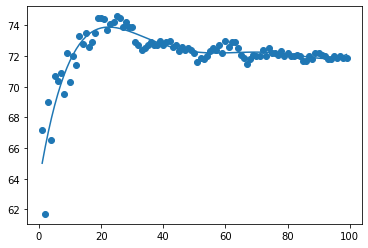

In [49]:
plt.scatter(k,accuracy)
z = np.polyfit(k, accuracy, 5)
p = np.poly1d(z)
plt.plot(k, p(k))

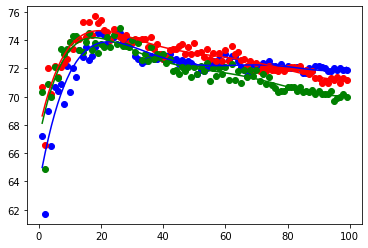

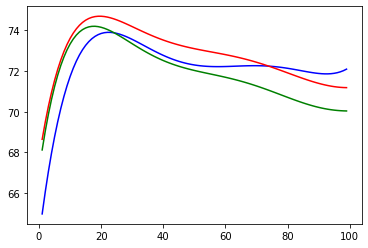

In [71]:
k = range(1,100)
accuracy2 = [knn(german_credit_data_original, "CreditRating", feature_list3, [1] * len(feature_list3) , x, 1) for x in k]
accuracy3 = [knn(german_credit_data_original, "CreditRating", feature_list4, [1] * len(feature_list4) , x, 1) for x in k]

# Set up plot areas
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

# Scatter plot on one axis
ax1.scatter(k,accuracy, color='blue', marker="o")
ax1.scatter(k,accuracy2, color='red', marker="o")
ax1.scatter(k,accuracy3, color='green', marker="o")

# Add trendlines
z1 = np.polyfit(k, accuracy, 6)
z2 = np.polyfit(k, accuracy2, 6)
z3 = np.polyfit(k, accuracy3, 6)
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)
p3 = np.poly1d(z3)
ax1.plot(k, p1(k), color='blue')
ax1.plot(k, p2(k), color='red')
ax1.plot(k, p3(k), color='green')

# Add just trendlines to a new plot
ax2.plot(k, p1(k), color='blue')
ax2.plot(k, p2(k), color='red')
ax2.plot(k, p3(k), color='green')